In [91]:
from mpl_toolkits import mplot3d 
import numpy as np 
import matplotlib.pyplot as plt
from math import sin, cos 
from analysis import make_points_maefit_2order
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d





In [92]:
def make_points_maefit_2order(npoints, k0, k2):

    def generate_angles_h(npoints):
        golden_angle = (3 - np.sqrt(5)) * np.pi
        theta = golden_angle * np.arange(npoints)
        Sz = np.linspace(1/npoints-1, 1-1/npoints, npoints)
        radius = np.sqrt(1 - Sz * Sz)
        Sy = radius * np.sin(theta)
        Sx = radius * np.cos(theta)
        saxes = np.round(np.array([Sx,Sy,Sz]).T, 4)
        saxes = saxes.tolist()
        phis = []
        thets = []


        def cart2sph_h(x, y, z):
            hxy = np.hypot(x, y)
            az = np.arctan2(z,hxy)
            pol = np.arctan2(y, x)
            return az, pol

        for spin in saxes:
            [phi, thet] = cart2sph_h(spin[0], spin[1], spin[2])
            phis.append(phi)
            thets.append(thet)
        return [phis, thets]
         

    def eval_fit_h(phi, thet, k0, k2):
        temp1 = k0 + k2[0,0]*(cos(phi)*sin(thet))**2 +k2[1,1]*(sin(thet)*sin(phi))**2 + k2[2,2]*(cos(thet))**2
        temp2 = (k2[0,1]+k2[1,0])*(cos(phi)*sin(phi)*(sin(thet)**2)) + (k2[1,2]+k2[2,1])*(cos(thet)*sin(thet)*sin(phi))
        return temp1 + temp2

    def spher2cart_h(thets, phis, rhos):
        X = []
        Y = []
        Z = []
        for i in range(len(phis)-1):
            x = rhos[i]*sin(thets[i])*cos(phis[i])
            y = rhos[i]*sin(thets[i])*sin(phis[i])
            z = rhos[i]*cos(thets[i])
            X.append(x)
            Y.append(y)
            Z.append(z)
            
        return [X, Y, Z]


    Uanis = []
    [phis, thets] = generate_angles_h(npoints)
    for i in range(npoints-1):
        Uanis.append(eval_fit_h(phis[i], thets[i], k0, k2))

    [Ex, Ey, Ez] = spher2cart_h(thets, phis, Uanis)
  
    return  [Ex, Ey, Ez]



class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

      

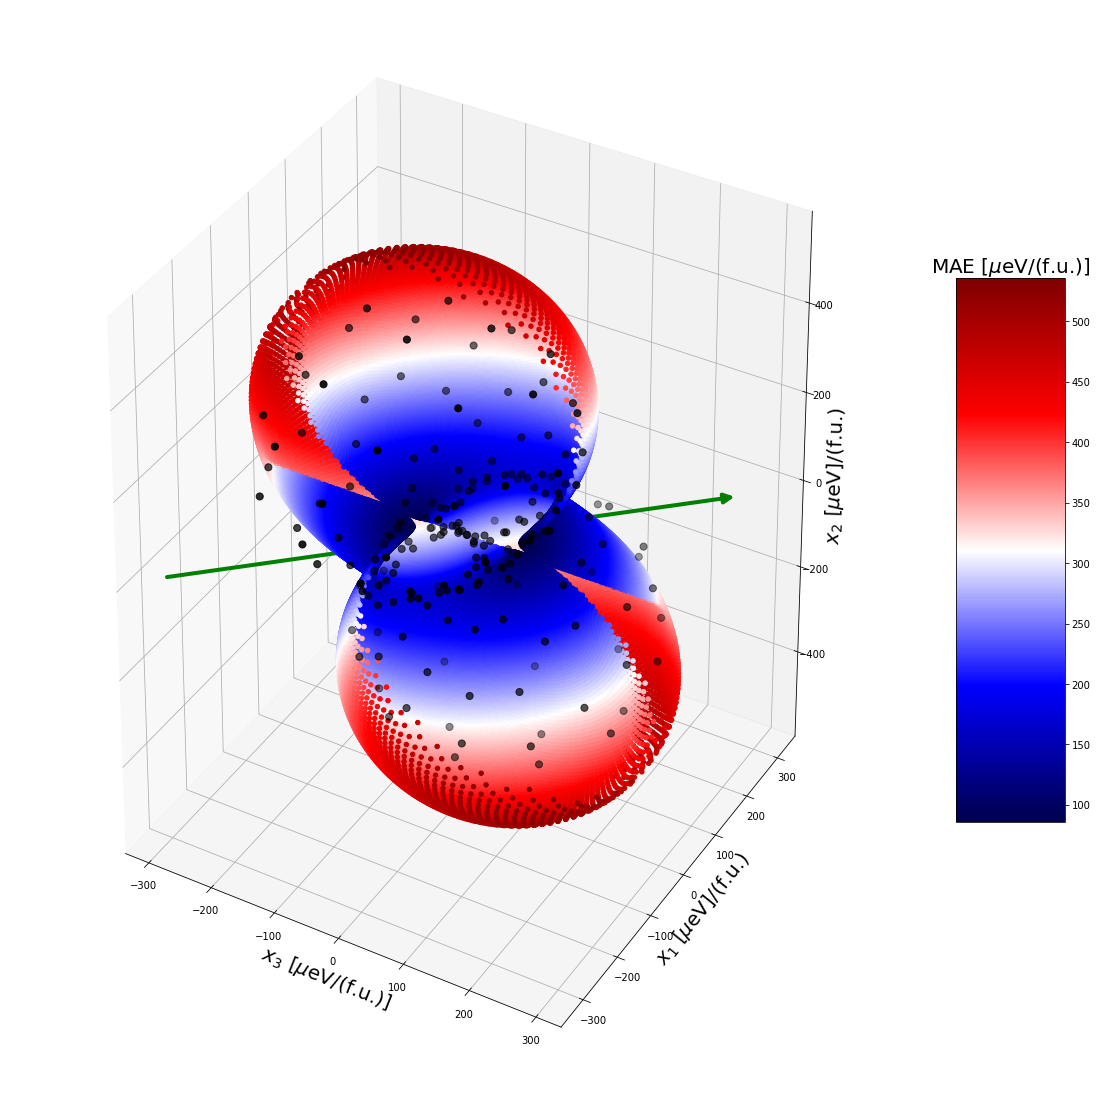

In [115]:
k0 = 86
k2 = np.array([[86.8502,0.51398,-0.95367],[0.51398,423.24,-106.166],[-0.95367,-106.166,26.4497]])
[x,y,z] = make_points_maefit_2order(100000, k0, k2)
mae=[] 
for i in range(len(z)): 
    mae.append(np.linalg.norm(np.array([x[i], y[i], z[i]])))
mae = np.array(mae)
x = np.array(x)
y = np.array(y)
z = np.array(z)

x_calc = np.loadtxt("mae_x.txt")
y_calc = np.loadtxt("mae_y.txt")
z_calc = np.loadtxt("mae_z.txt")

fig = plt.figure(figsize = (20, 20)) 
ax = fig.gca(projection='3d')
my_cmap = plt.get_cmap('seismic') 
sctt = ax.scatter3D(z, x, y, alpha = 1, c = mae[0:len(mae)],  
                   cmap = my_cmap) 
sctt2 = ax.scatter3D(z_calc, x_calc, y_calc, s=50 ,color='black', marker ='o')
clb = fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5) 
clb.ax.set_title('MAE [$\mu$eV/(f.u.)]', fontsize=20)
arrow =  Arrow3D([-300,275], [-300, 275], [0, 0], mutation_scale=20, lw=4, arrowstyle="-|>", color="g")
ax.add_artist(arrow)
plt.draw() 
ax.set_xlabel('$x_{3}$ [$\mu$eV/(f.u.)]', fontsize=20)  
ax.set_ylabel('$x_{1}$ [$\mu$eV]/(f.u.)', fontsize=20)  
ax.set_zlabel('$x_{2}$ [$\mu$eV]/(f.u.)', fontsize=20) 
plt.show()